# 2022-04-04 Differentiation

## Last time

* Nonlinear models
* Computing derivatives
  * numeric
  * analytic by hand
  
## Today

* Project feedback
* Computing derivatives in maintainable code
* Forward and reverse
* Algorithmic (automatic) differentiation


In [5]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

function grad_descent(loss, grad, c0; gamma=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    c = copy(c0)
    chist = [copy(c)]
    lhist = [loss(c)]
    for it in 1:500
        g = grad(c)
        c -= gamma * g
        push!(chist, copy(c))
        push!(lhist, loss(c))
        if norm(g) < tol
            break
        end
    end
    (c, hcat(chist...), lhist)
end

grad_descent (generic function with 1 method)

# Constructive project feedback/questions

* You can start now: look at a few projects in `#sharing` on Zulip

## Examples
* Explain (in a sentence or two) something you learned:
> It was neat to see how interpolation showed up in this graphics application, and how B-splines were used to have both sharp corners and smooth curves in the same representation.
* Ask a question about the software, the underlying math, or about how people interact with or are affected by the software.
* Give a suggestion for improving or extending the project, or a new perspective by which to understand its context.

# Nonlinear models

Instead of the linear model
$$ f(x,c) = V(x) c = c_0 + c_1 \underbrace{x}_{T_1(x)} + c_2 T_2(x) + \dotsb $$
let's consider a rational model with only three parameters
$$ f(x,c) = \frac{1}{c_1 + c_2 x + c_3 x^2} = (c_1 + c_2 x + c_3 x^2)^{-1} . $$
We'll use the same loss function
$$ L(c; x,y) = \frac 1 2 \lVert f(x,c) - y \rVert^2 . $$

We will also need the gradient
$$ \nabla_c L(c; x,y) = \big( f(x,c) - y \big)^T \nabla_c f(x,c) $$
where
\begin{align}
\frac{\partial f(x,c)}{\partial c_1} &= -(c_1 + c_2 x + c_3 x^2)^{-2} = - f(x,c)^2 \\
\frac{\partial f(x,c)}{\partial c_2} &= -(c_1 + c_2 x + c_3 x^2)^{-2} x = - f(x,c)^2 x \\
\frac{\partial f(x,c)}{\partial c_3} &= -(c_1 + c_2 x + c_3 x^2)^{-2} x^2 = - f(x,c)^2 x^2 .
\end{align}

# Fitting a rational function

In [22]:
f(x, c) = 1 ./ (c[1] .+ c[2].*x + c[3].*x.^2)
function gradf(x, c)
    f2 = f(x, c).^2
    [-f2 -f2.*x -f2.*x.^2]
end
function loss(c)
    r = f(x, c) - y
    0.5 * r' * r
end
function gradient(c)
    r = f(x, c) - y
    vec(r' * gradf(x, c))
end

gradient (generic function with 1 method)

c = [1.189773116107557, 0.37072648768485034, 6.165752708060916]


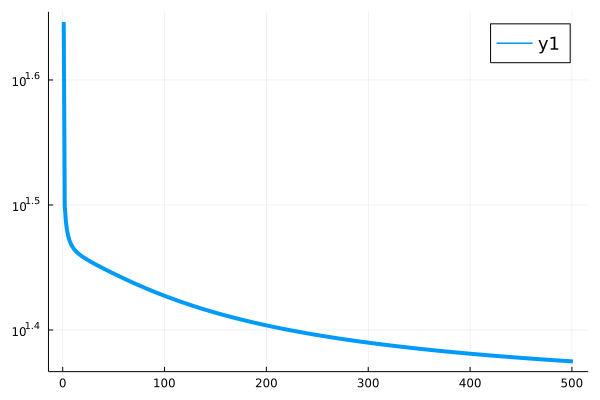

In [23]:
x = LinRange(-1, 1, 200)
y = runge_noisy(x, .5)
c, _, lhist = grad_descent(loss, gradient, [1., 0, 1.],
    gamma=1e-2)
@show c
plot(lhist, yscale=:log10)

# Compare fits on noisy data

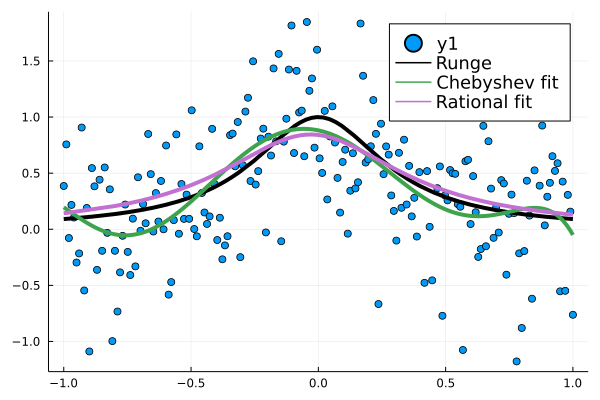

In [26]:
scatter(x, y)
V = vander_chebyshev(x, 7)
plot!(x -> runge(x), color=:black, label="Runge")
plot!(x, V * (V \ y), label="Chebyshev fit")
plot!(x -> f(x, c), label="Rational fit")

# How do we compute those derivatives as the model gets complicated?

$$\lim_{h\to 0} \frac{f(x+h) - f(x)}{h}$$

* How should we choose $h$?
* Too big: discretization error dominates (think of truncating the Taylor series)
* Too small: rounding error dominates

# Automatic step size selection

* Walker and Pernice
* Dennis and Schnabel

In [12]:
diff(f, x; h=1e-8) = (f(x+h) - f(x)) / h

function diff_wp(f, x; eps=1e-8)
    """Diff using Walker and Pernice (1998) choice of step"""
    h = eps * (1 + abs(x))
    (f(x+h) - f(x)) / h
end

x = 1
diff_wp(sin, x) - cos(x)

-2.9698852266335507e-9

# Symbolic differentiation

In [27]:
using Symbolics

@variables x
Dx = Differential(x)

y = sin(x)
Dx(y)

Differential(x)(sin(x))

In [28]:
expand_derivatives(Dx(y))

cos(x)

# Awesome, what about products?

In [30]:
y = x
for _ in 1:2
    y = cos(y^pi) * log(y)
end
expand_derivatives(Dx(y))

((x^-1)*cos(x^π) - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*(log(x)^-1)*(cos(x^π)^-1)*cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793)) - (3.141592653589793(x^-1)*(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793) - 9.869604401089358(x^2.141592653589793)*(log(x)^3.141592653589793)*(cos(x^π)^2.141592653589793)*sin(x^π))*sin((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))*log(log(x)*cos(x^π))

* The size of these expressions can grow **exponentially**

# Hand-coding derivatives

$$ df = f'(x) dx $$

In [31]:
function f(x)
    y = x
    for _ in 1:2
        a = y^pi
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), diff_wp(f, 1.9)

(-1.5346823414986814, -34.032439961925064)

In [32]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y ^ pi
        da = pi * y^(pi - 1) * dy
        b = cos(a)
        db = -sin(a) * da
        c = log(y)
        dc = 1/y * dy
        y = b * c
        dy = db * c + b * dc
    end
    y, dy
end

df(1.9, 1)

(-1.5346823414986814, -34.03241959914048)

# We can go the other way

We can differentiate a composition $h(g(f(x)))$ as

\begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x.
\end{align}

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

The expression means the same thing if we rearrange the parentheses,

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

which we can compute with in reverse order via

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

# A reverse mode example

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

In [20]:
function g(x)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    y
end
(g(1.4), diff_wp(g, 1.4))

(-0.32484122107701546, -1.2559760384500684)

In [21]:
function gback(x, y_)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    # backward pass
    c_ = y_ * b 
    b_ = c * y_
    a_ = -sin(a) * b_
    x_ = 1/x * c_ + pi * x^(pi-1) * a_
    x_
end
gback(1.4, 1)

-1.2559761698835525

# Automatic differentiation

In [33]:
using Zygote

In [34]:
Zygote.gradient(f, 1.9)

(-34.03241959914049,)

# How does Zygote work?

In [41]:
square(x) = x^2
@code_llvm square(1.5)

;  @ In[41]:1 within `square`
define double @julia_square_10931(double %0) #0 {
top:
; ┌ @ intfuncs.jl:312 within `literal_pow`
; │┌ @ float.jl:405 within `*`
    %1 = fmul double %0, %0
; └└
  ret double %1
}


In [30]:
@code_llvm Zygote.gradient(square, 1.5)

;  @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:74 within `gradient`
define [1 x double] @julia_gradient_11254(double %0) #0 {
top:
;  @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:76 within `gradient`
; ┌ @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:41 within `#56`
; │┌ @ In[26]:1 within `Pullback`
; ││┌ @ /home/jed/.julia/packages/ZygoteRules/AIbCs/src/adjoint.jl:67 within `#1822#back`
; │││┌ @ /home/jed/.julia/packages/Zygote/H6vD3/src/lib/number.jl:6 within `#254`
; ││││┌ @ promotion.jl:380 within `*` @ float.jl:405
       %1 = fmul double %0, 2.000000e+00
; └└└└└
;  @ /home/jed/.julia/packages/Zygote/H6vD3/src/compiler/interface.jl:77 within `gradient`
  %.fca.0.insert = insertvalue [1 x double] zeroinitializer, double %1, 0
  ret [1 x double] %.fca.0.insert
}


# Kinds of algorithmic differentation

* Source transformation: Fortran code in, Fortran code out
  * Duplicates compiler features, usually incomplete language coverage
  * Produces efficient code
* Operator overloading: C++ types
  * Hard to vectorize
  * Loops are effectively unrolled/inefficient
* Just-in-time compilation: tightly coupled with compiler
  * JIT lag
  * Needs dynamic language features (JAX) or tight integration with compiler (Zygote, Enzyme)
  * Some [sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow)

# Forward or reverse?

It all depends on the shape.

* One input, many outputs: use forward mode
  * "One input" can be looking in one direction
* Many inputs, one output: use reverse mode
  * Will need to traverse execution backwards ("tape")
  * Hierarchical checkpointing
* About square? Forward is usually a bit more efficient.

# Ill-conditioned optimization

$$ L(c; x, y) = \frac 1 2 \lVert \underbrace{f(x, c) - y}_{r(c)} \rVert_{C^{-1}}^2 $$

Gradient of $L$ requires the Jacobian $J$ of the model $f$.

$$ g(c) = \nabla_c L = r^T \underbrace{\nabla_c f}_{J} $$

We can solve $g(c) = 0$ using a Newton method

$$ g(c + \delta c) = g(c) + \underbrace{\nabla_c g}_H\delta c + O((\delta c)^2) $$

The Hessian requires the second derivative of $f$, which can cause problems.

$$ H = J^T J + r^T (\nabla_c J)$$

# Newton-like methods for optimization

Solve

$$ H \delta c = -g(c) $$

Update $c \gets c + \gamma \delta c$$ using a line search or trust region.

# Outlook

* The optimization problem can be solved using a Newton method.  It can be onerous to implement the needed derivatives.
* The [Gauss-Newton method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) (see activity) is often more practical than Newton while being faster than gradient descent, though it lacks robustness.
* The [Levenberg-Marquardt method](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) provides a sort of middle-ground between Gauss-Newton and gradient descent.
* Many globalization techniques are used for models that possess many local minima.
* One pervasive approach is stochastic gradient descent, where small batches (e.g., 1 or 10 or 20) are selected randomly from the corpus of observations (500 in our current example), and a step of gradient descent is applied to that reduced set of observations.  This helps to escape saddle points and weak local minima.
* Among expressive models $f(x,c)$, some may converge much more easily than others.  Having a good optimization algorithm is essential for nonlinear regression with complicated models, especially those with many parameters $c$.
* Classification is a very similar problem to regression, but the observations $y$ are discrete, thus

 * models $f(x,c)$ must have discrete output
 * the least squares loss function is not appropriate.
* [Why momentum really works](https://distill.pub/2017/momentum/)